# Naive Bayes and Logistic Regression

Importamos librerías.

In [31]:
import os, re
from pathlib import Path
from typing import Iterable

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Cargar documentos

In [2]:
twenty_n_regex = r'''
^From:.*?\n|                      # Ignora la línea que empieza con 'From:' y lo que sigue hasta el final de la línea
^Subject:(?:\s*Re:\s*)?(.*)\n|    # Captura el texto del 'Subject' y elimina 'Subject:' o 'Re:'
.*Date:.*?\n|                      # Ignora la línea que empieza con 'Date:'
^Archive-name:.*?\n|              # Ignora la línea que empieza con 'Archive-name:' y lo que sigue hasta el final de la línea
^Alt-atheism-archive-name:.*?\n|  # Ignora la línea que empieza con 'Alt-atheism-archive-name:' y lo que sigue hasta el final de la línea
^Last-modified:.*?\n|             # Ignora la línea que empieza con 'Last-modified:' y lo que sigue hasta el final de la línea
^Version:.*?\n|                   # Ignora la línea que empieza con 'Version:' y lo que sigue hasta el final de la línea
^.*@.*?\n|                        # Ignora la línea que contiene '@' y lo que sigue hasta el final de la línea
In\sarticle.*?writes:\n|          # Ignora todo lo que está entre 'In article...' y 'writes:'
.*Newsgroups:.*?\n|               # Ignora cualquier línea que contenga 'Newsgroups:'
[^a-zA-Z0-9\s.,]                  # Elimina cualquier carácter que no sea una letra, un número o un espacio
|^>+                              # Elimina '>' al inicio de una línea
|\s*>+                            # Elimina '>' seguido por espacios
^-+$                              # Ignora las líneas que contienen solo '-'
^=+$                              # Ignora las líneas que contienen solo '='
'''

class DocumentPreprocessor:
    """
    Clase para preprocesar documentos de texto. 
    Incluye eliminación de stop words, lematización y tokenización.
    
    Args:
        stop_words (Iterable[str], opcional): Lista de stop words a eliminar. Por defecto, se usa el conjunto de stopwords de NLTK.
        lemmatizer (WordNetLemmatizer, opcional): Lematizador para procesar las palabras. Por defecto, se usa WordNetLemmatizer de NLTK.
    """
    
    def __init__(self, stop_words: Iterable[str] = None, lemmatizer: WordNetLemmatizer = None):
        # Usar stop words predeterminadas si no se especifican
        self.stop_words = stop_words or set(stopwords.words('english'))
        # Usar el lematizador predeterminado si no se especifica
        self.lemmatizer = lemmatizer or WordNetLemmatizer()

    def fit(self, X, y=None):
        """
        Ajusta el preprocesador (Método placeholder para cumplir con el API de sklearn).
        
        Args:
            X (pd.Series): Datos de entrada.
            y (pd.Series, opcional): Etiquetas. No utilizado.
        
        Returns:
            self: Retorna la instancia del preprocesador.
        """
        return self

    def transform(self, X, y=None):
        """
        Transforma los documentos de entrada aplicando el preprocesamiento.
        
        Args:
            X (pd.Series): Serie de documentos de texto.
            y (pd.Series, opcional): Etiquetas. No utilizado.
        
        Returns:
            pd.Series: Serie de documentos procesados.
        """
        return pd.Series([self.preprocess_document(doc) for doc in X])

    def preprocess_document(self, doc: str) -> str:
        """
        Aplica el preprocesamiento a un solo documento.
        
        Args:
            doc (str): Texto del documento.
        
        Returns:
            str: Texto preprocesado.
        """
        # Tokenizar el documento
        tokens = word_tokenize(doc)
        # Lemmatizar, convertir a minúsculas, eliminar stop words y caracteres no alfanuméricos
        tokens = [self.lemmatizer.lemmatize(token.lower()) for token in tokens 
                  if token.lower() not in self.stop_words and token.isalnum()]
        # Retornar el documento procesado como una única cadena
        return ' '.join(tokens)


def load_news_documents(dataset_path: Path) -> pd.DataFrame:
    """
    Carga documentos de noticias desde un conjunto de datos estructurado en carpetas.
    Cada carpeta representa una clase de documento.
    
    Args:
        dataset_path (Path): Ruta al directorio que contiene el dataset.
    
    Returns:
        pd.DataFrame: DataFrame con los nombres de documentos, clases y textos procesados.
    """
    document_names = []
    document_texts = []
    document_classes = []

    # Lista las carpetas/clases dentro del dataset
    dataset_classnames = os.listdir(dataset_path)

    for doc_class in dataset_classnames:
        # Construir la ruta de la clase
        class_path = os.path.join(dataset_path, doc_class)
        file_names = os.listdir(class_path)

        for file_name in file_names:
            # Construir la ruta del archivo
            file_path = os.path.join(class_path, file_name)

            document_names.append(file_name)
            document_classes.append(doc_class)
            
            try:
                # Leer el archivo de texto
                with open(file_path, 'r', encoding='ISO-8859-1') as f:
                    text = f.read()
                    # Limpiar el texto utilizando una expresión regular
                    cleaned_text = re.sub(twenty_n_regex, '', text, flags=re.VERBOSE | re.MULTILINE).replace("rh", "")
                    document_texts.append(cleaned_text)
            except Exception as e:
                print(f"Error al procesar el archivo {file_path}: {e}")
                continue

    # Crear un DataFrame con los datos cargados
    return pd.DataFrame(
        {'document_name': document_names, 'document_class': document_classes, 'document_text': document_texts}
    )

Cargamos los documentos. En este momento solo se están limpiando con expresiones regulares.

In [3]:
dataset = load_news_documents('data/20news-18828/20news-18828')
dataset.head()

,document_name,document_class,document_text
0,49960,alt.atheism,\n\n Atheist Reso...
1,51060,alt.atheism,\n\nBEGIN PGP SIGNED MESSAGE\n\n ...
2,51119,alt.atheism,"\n \nWell, John has a quite different, not nec..."
3,51120,alt.atheism,"\n Recently, RAs have been ordered and no..."
4,51121,alt.atheism,"\n\n 1 HOWEVER, I hate economic terrorism and ..."


## Exploración inicial y separación de datos

Tambien observamos la proporción de clases. El tipo de documentos con menor cantidad de datos es `talk.religion.misc` con 628, y el que más tiene es `rec.sport.hockey` con 999, lo que representa un desbalanceo de 371 clases. Sin embargo, en general, el dataset está bien balanceado.

In [4]:
dataset["document_class"].value_counts()

document_class
rec.sport.hockey            999
soc.religion.christian      997
rec.sport.baseball          994
rec.motorcycles             994
sci.crypt                   991
rec.autos                   990
sci.med                     990
sci.space                   987
comp.os.ms-windows.misc     985
comp.sys.ibm.pc.hardware    982
sci.electronics             981
comp.windows.x              980
comp.graphics               973
misc.forsale                972
comp.sys.mac.hardware       961
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: count, dtype: int64

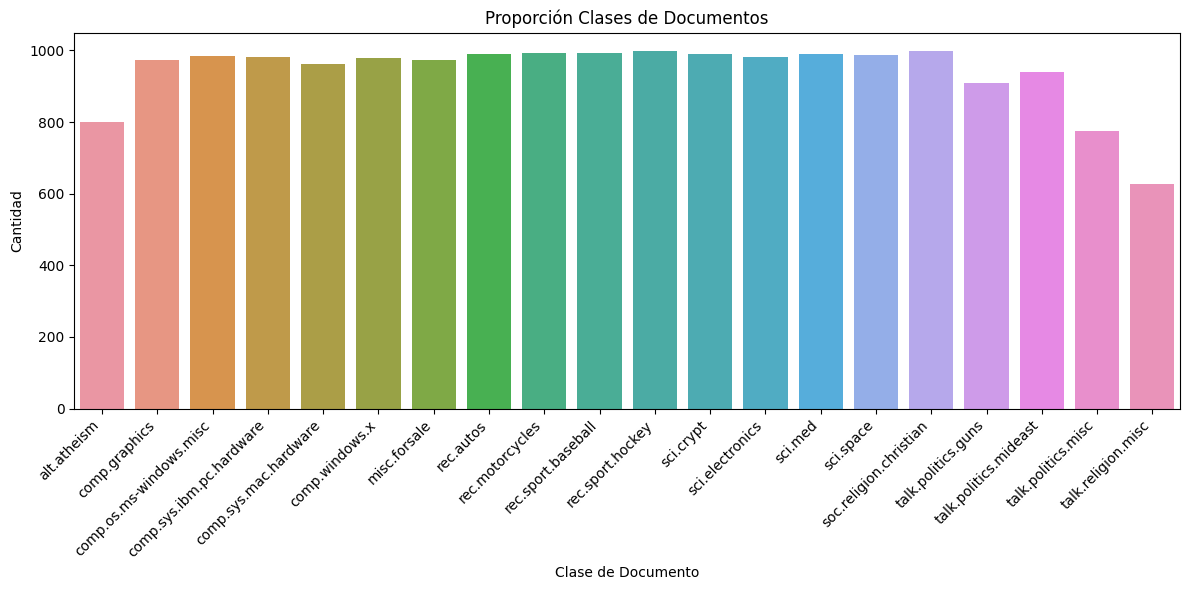

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(x='document_class', data=dataset)

plt.title('Proporción Clases de Documentos')
plt.xlabel('Clase de Documento')
plt.ylabel('Cantidad')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Dividimos el conjunto en entrenamiento (60%), validación (10%) y testeo (30%).

In [6]:
train_df, remaining_df = train_test_split(dataset, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.75, random_state=42)

In [7]:
len(train_df), len(val_df), len(test_df)

(11296, 1883, 5649)

Creamos nuestra instancia de `DocumentPreprocessor`. Esta va a aplicar un preprocesamiento de texto que consiste en lemmatizar, convertir a minúsculas, eliminar stop words y caracteres no alfanuméricos.

In [8]:
document_preprocessor = DocumentPreprocessor()
X_train = document_preprocessor.transform(train_df['document_text'])
X_val = document_preprocessor.transform(val_df['document_text'])
X_test = document_preprocessor.transform(test_df['document_text'])

In [9]:
y_train = train_df['document_class']
y_val = val_df['document_class']
y_test = test_df['document_class']

## Regresión Logística

Consideramos dos enfoques: uno con conteo de tokens (`CountVectorizer`) y otro con TF-IDF (`TfidfVectorizer`).

In [10]:
# Crear y entrenar el pipeline
pipeline_c_lr = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

pipeline_c_lr.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

Precisión del modelo: 0.8118


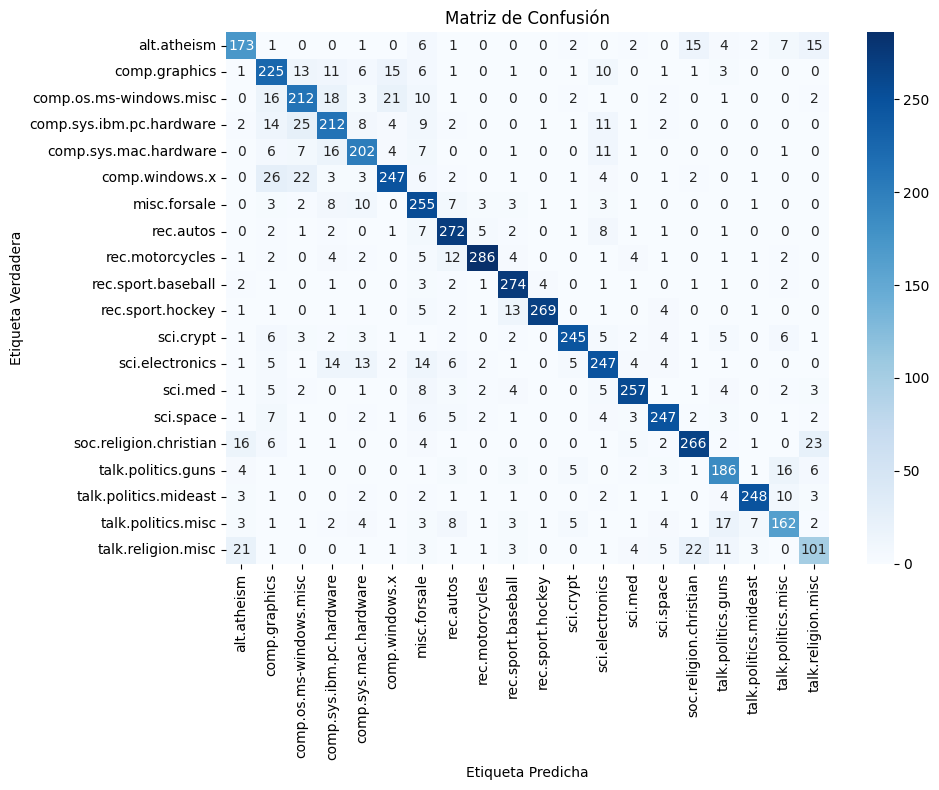


Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.76      0.75       229
           comp.graphics       0.68      0.76      0.72       295
 comp.os.ms-windows.misc       0.73      0.73      0.73       289
comp.sys.ibm.pc.hardware       0.72      0.73      0.72       292
   comp.sys.mac.hardware       0.77      0.79      0.78       256
          comp.windows.x       0.83      0.77      0.80       319
            misc.forsale       0.71      0.86      0.77       298
               rec.autos       0.82      0.89      0.86       304
         rec.motorcycles       0.94      0.88      0.91       326
      rec.sport.baseball       0.86      0.93      0.90       294
        rec.sport.hockey       0.97      0.90      0.93       300
               sci.crypt       0.91      0.84      0.88       290
         sci.electronics       0.78      0.77      0.77       321
                 sci.med       0.89      0.86   

In [11]:
# Hacer predicciones
y_pred = pipeline_c_lr.predict(X_test)

# Calcular la precisión
accuracy = pipeline_c_lr.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener los nombres de las clases
class_names = pipeline_c_lr.named_steps['classifier'].classes_

# Crear un DataFrame de la matriz de confusión con los nombres de las clases
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Crear un mapa de calor de la matriz de confusión con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# Generar y mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

In [12]:
# Crear y entrenar el pipeline
pipeline_tfidf_lr = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

pipeline_tfidf_lr.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

Precisión del modelo: 0.8456


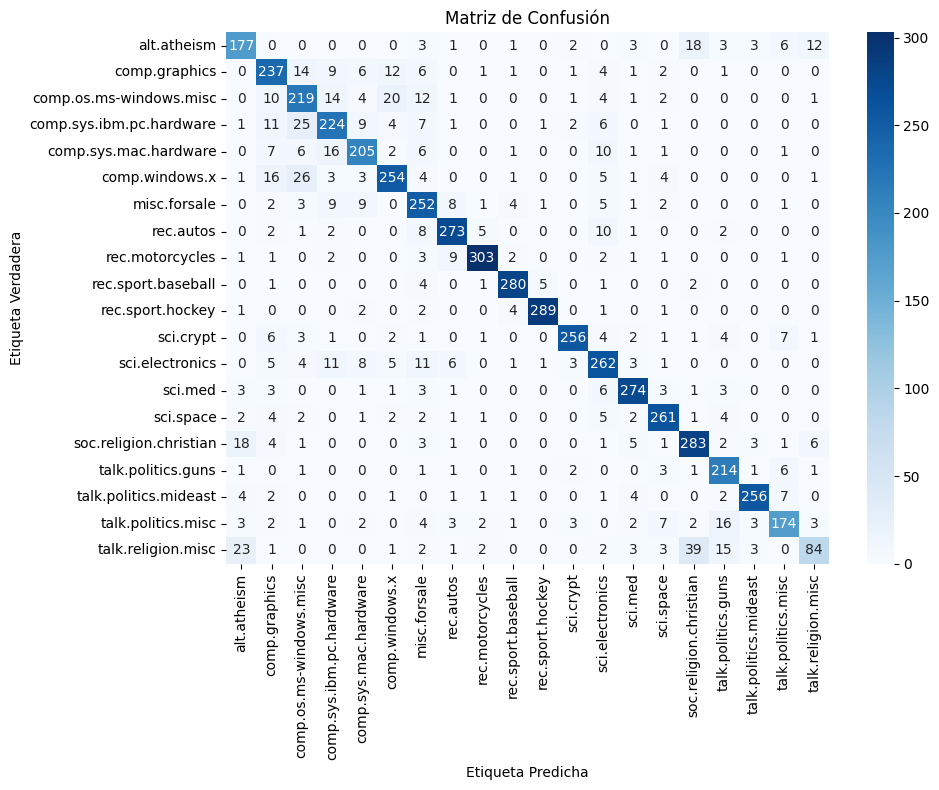


Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.77      0.76       229
           comp.graphics       0.75      0.80      0.78       295
 comp.os.ms-windows.misc       0.72      0.76      0.74       289
comp.sys.ibm.pc.hardware       0.77      0.77      0.77       292
   comp.sys.mac.hardware       0.82      0.80      0.81       256
          comp.windows.x       0.84      0.80      0.82       319
            misc.forsale       0.75      0.85      0.80       298
               rec.autos       0.89      0.90      0.89       304
         rec.motorcycles       0.95      0.93      0.94       326
      rec.sport.baseball       0.94      0.95      0.95       294
        rec.sport.hockey       0.97      0.96      0.97       300
               sci.crypt       0.95      0.88      0.91       290
         sci.electronics       0.80      0.82      0.81       321
                 sci.med       0.90      0.92   

In [13]:
# Hacer predicciones
y_pred = pipeline_tfidf_lr.predict(X_test)

# Calcular la precisión
accuracy = pipeline_tfidf_lr.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener los nombres de las clases
class_names = pipeline_tfidf_lr.named_steps['classifier'].classes_

# Crear un DataFrame de la matriz de confusión con los nombres de las clases
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Crear un mapa de calor de la matriz de confusión con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# Generar y mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

## Naive Bayes

En este caso, `Naive Bayes` necesita la matriz densa, en lugar de la dispersa que por defecto retornan `CountVectorizer` y `TfidfVectorizer`. Para eso definimos una función de transformación para incluir en el pipeline que hace esto.

In [14]:
transform_sparse = FunctionTransformer(lambda X: np.asarray(X.todense()))

In [15]:
pipeline_c_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('to_dense', transform_sparse),
    ('classifier', GaussianNB())
])

pipeline_c_nb.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('to_dense',
                 FunctionTransformer(func=<function <lambda> at 0x000002AE08208720>)),
                ('classifier', GaussianNB())])

Precisión del modelo: 0.7793


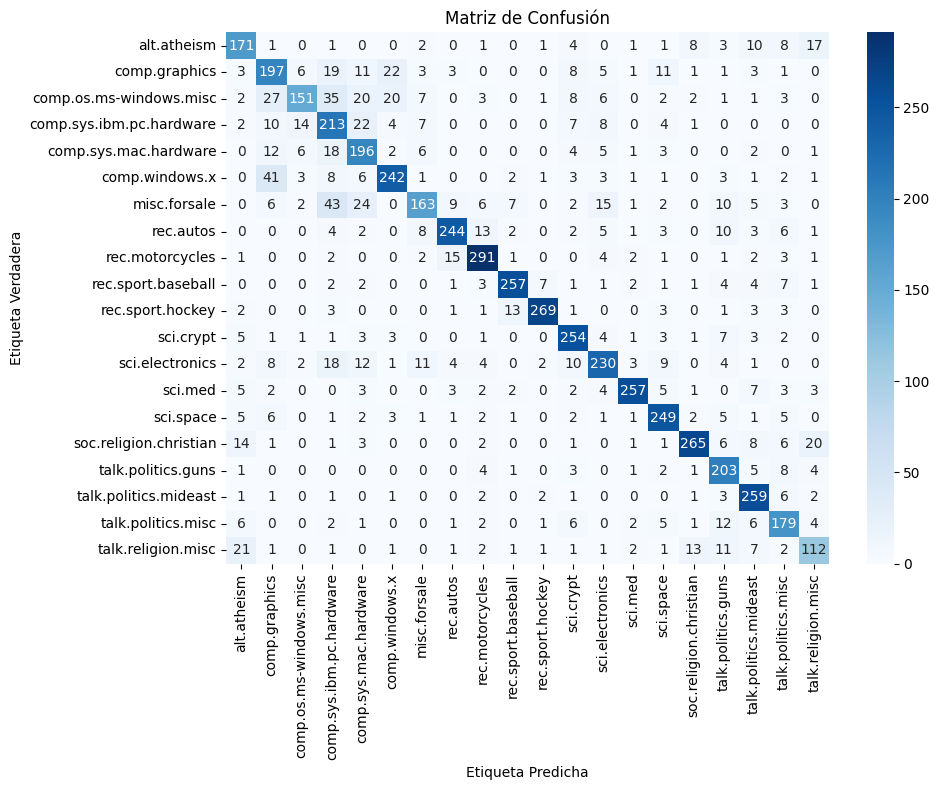


Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.71      0.75      0.73       229
           comp.graphics       0.63      0.67      0.65       295
 comp.os.ms-windows.misc       0.82      0.52      0.64       289
comp.sys.ibm.pc.hardware       0.57      0.73      0.64       292
   comp.sys.mac.hardware       0.64      0.77      0.70       256
          comp.windows.x       0.81      0.76      0.78       319
            misc.forsale       0.77      0.55      0.64       298
               rec.autos       0.86      0.80      0.83       304
         rec.motorcycles       0.86      0.89      0.88       326
      rec.sport.baseball       0.90      0.87      0.88       294
        rec.sport.hockey       0.94      0.90      0.92       300
               sci.crypt       0.79      0.88      0.83       290
         sci.electronics       0.79      0.72      0.75       321
                 sci.med       0.92      0.86   

In [16]:
# Hacer predicciones
y_pred = pipeline_c_nb.predict(X_test)

# Calcular la precisión
accuracy = pipeline_c_nb.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener los nombres de las clases
class_names = pipeline_c_nb.named_steps['classifier'].classes_

# Crear un DataFrame de la matriz de confusión con los nombres de las clases
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Crear un mapa de calor de la matriz de confusión con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# Generar y mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

In [17]:
pipeline_tfidf_nb = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000)),
    ('to_dense', transform_sparse),
    ('classifier', GaussianNB())
])

pipeline_tfidf_nb.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=10000)),
                ('to_dense',
                 FunctionTransformer(func=<function <lambda> at 0x000002AE08208720>)),
                ('classifier', GaussianNB())])

Precisión del modelo: 0.6860


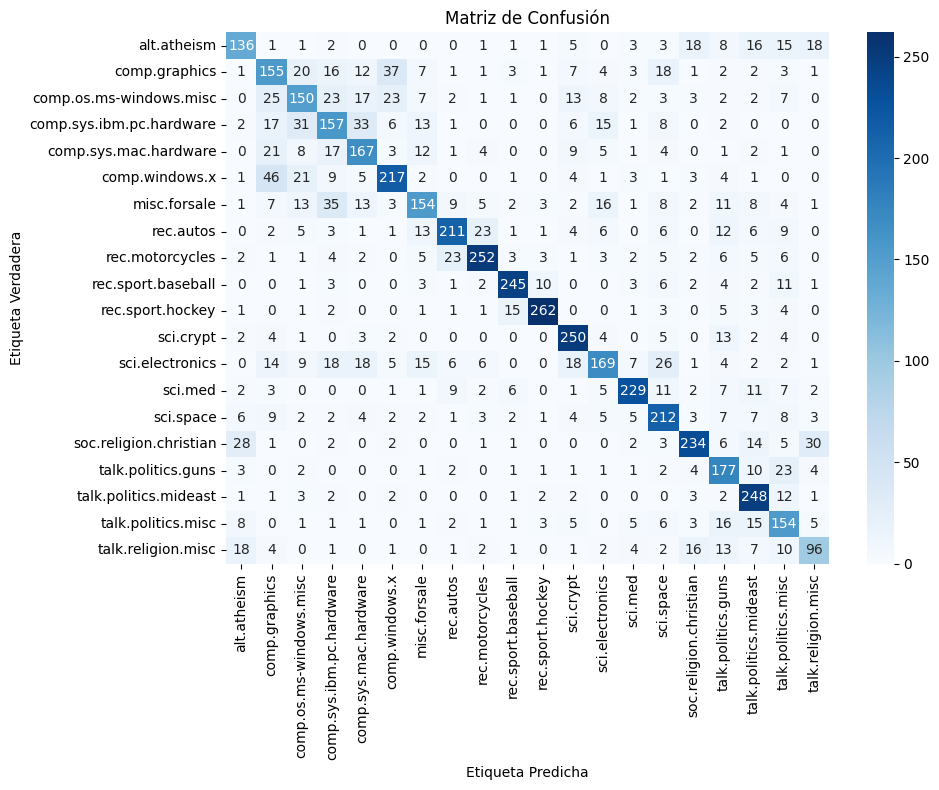


Reporte de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.64      0.59      0.62       229
           comp.graphics       0.50      0.53      0.51       295
 comp.os.ms-windows.misc       0.56      0.52      0.54       289
comp.sys.ibm.pc.hardware       0.53      0.54      0.53       292
   comp.sys.mac.hardware       0.61      0.65      0.63       256
          comp.windows.x       0.71      0.68      0.70       319
            misc.forsale       0.65      0.52      0.58       298
               rec.autos       0.78      0.69      0.73       304
         rec.motorcycles       0.83      0.77      0.80       326
      rec.sport.baseball       0.86      0.83      0.85       294
        rec.sport.hockey       0.91      0.87      0.89       300
               sci.crypt       0.75      0.86      0.80       290
         sci.electronics       0.69      0.53      0.60       321
                 sci.med       0.84      0.77   

In [18]:
# Hacer predicciones
y_pred = pipeline_tfidf_nb.predict(X_test)

# Calcular la precisión
accuracy = pipeline_tfidf_nb.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener los nombres de las clases
class_names = pipeline_tfidf_nb.named_steps['classifier'].classes_

# Crear un DataFrame de la matriz de confusión con los nombres de las clases
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Crear un mapa de calor de la matriz de confusión con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# Generar y mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

## Cross-validation

Para la validación cruzada vamos a juntar los conjuntos de entrenamiento y validación.

In [19]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

### Búsqueda de hiperparámetros - CV - Regresión Logística

In [36]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'] 
}


pipeline_tfidf_lr = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver='sag', max_iter=10000))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline_tfidf_lr, param_grid, cv=kf, verbose=2)
grid_search.fit(X_train_val, y_train_val)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(X_train_val)

precision_macro = precision_score(y_train_val, y_pred, average='macro')
recall_macro = recall_score(y_train_val, y_pred, average='macro')
f1_macro = f1_score(y_train_val, y_pred, average='macro')

precision_micro = precision_score(y_train_val, y_pred, average='micro')
recall_micro = recall_score(y_train_val, y_pred, average='micro')
f1_micro = f1_score(y_train_val, y_pred, average='micro')

print("Training metrics:\n")
print(f"Precision (Macro): {precision_macro}")
print(f"Recall (Macro): {recall_macro}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"Precision (Micro): {precision_micro}")
print(f"Recall (Micro): {recall_micro}")
print(f"F1 Score (Micro): {f1_micro}")

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   0.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l2; total time=   2.0s
[CV] END ..........classifier__C=0.1, classifier

### CV - Naive Bayes

In [37]:
pipeline_tfidf_nb = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('to_dense', transform_sparse),
    ('classifier', GaussianNB())
])

y_pred_cv = cross_val_predict(pipeline_tfidf_nb, X_train_val, y_train_val, cv=kf, verbose=2)

precision_macro = precision_score(y_train_val, y_pred_cv, average='macro')
recall_macro = recall_score(y_train_val, y_pred_cv, average='macro')
f1_macro = f1_score(y_train_val, y_pred_cv, average='macro')

precision_micro = precision_score(y_train_val, y_pred_cv, average='micro')
recall_micro = recall_score(y_train_val, y_pred_cv, average='micro')
f1_micro = f1_score(y_train_val, y_pred_cv, average='micro')

print("Training metrics:\n")
print(f"Precision (Macro): {precision_macro}")
print(f"Recall (Macro): {recall_macro}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"Precision (Micro): {precision_micro}")
print(f"Recall (Micro): {recall_micro}")
print(f"F1 Score (Micro): {f1_micro}")

Training metrics:

Precision (Macro): 0.7768577846245562
Recall (Macro): 0.7753594445617217
F1 Score (Macro): 0.7737104758515806
Precision (Micro): 0.779345929129676
Recall (Micro): 0.779345929129676
F1 Score (Micro): 0.7793459291296762


In [38]:
pipeline_tfidf_nb.fit(X_train_val, y_train_val)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('to_dense',
                 FunctionTransformer(func=<function <lambda> at 0x000002AE08208720>)),
                ('classifier', GaussianNB())])

## Evaluation

Evaluamos los modelos obtenidos en el paso anterior para el conjunto de testing.

In [41]:
def evaluate_model(model, X_test, y_test):
    """
    Evalúa el rendimiento de un modelo de clasificación en los datos de prueba.

    Args:
        model : object
            El modelo de clasificación entrenado.
        X_test : array-like
            Conjunto de datos de testing (características) sobre los cuales se realizarán las predicciones.
        y_test : array-like
            Etiquetas reales de los datos de testing.

    Returns:
        dict
            Un diccionario que contiene los valores de precisión, recall y F1-score tanto en promedio macro como micro.
    """
    # Predicción en los datos de testing
    y_pred = model.predict(X_test)

    # Cálculo de las métricas en promedio macro (trata todas las clases de manera equitativa)
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Cálculo de las métricas en promedio micro (pondera por el tamaño de la clase)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')

    # Imprime los resultados
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")

    # Retornar las métricas como un diccionario
    return {
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro
    }

In [42]:
r_log_reg = evaluate_model(grid_search.best_estimator_, X_test, y_test)

Precision (Macro): 0.8741
Recall (Macro): 0.8712
F1 Score (Macro): 0.8723
Precision (Micro): 0.8759
Recall (Micro): 0.8759
F1 Score (Micro): 0.8759


In [43]:
r_naive_bayes = evaluate_model(pipeline_tfidf_nb, X_test, y_test)

Precision (Macro): 0.7962
Recall (Macro): 0.7958
F1 Score (Macro): 0.7933
Precision (Micro): 0.7987
Recall (Micro): 0.7987
F1 Score (Micro): 0.7987
